# Outlier Detector Version One
We use SciKit-Learn's anomaly detection algorithm to build a simple model based on relative height metrics. We will use robust covariance (Gaussian fit).
Note to self:
- Features to add: Time of day, laser strength, long, lat, solar elev., azimuth ...
- Assemble a massive file with all the data; each row is a shot
- Use more files from GDrive, get 1000 files
- Do a PCA on the massive file (exploratory data analysis)
- Probably 1 or 2 RH metrics are enough for RH
- Instrumentation data may work too
- For clustering to work, we need to know where each cluster is -- we're really modeling the covariance matrices
- "Given this set of data, can this point be drawn from this cov matrix?"
- Look at cov within consecutive shots
- Learn from different passes at different times (how?)
- Idea: being aware of context

In [1]:
import os
import random

import h5py
import numpy as np
import pandas as pd
import geopandas as gp
# import geoviews as gv
# from geoviews import opts, tile_sources as gvts
# import holoviews as hv
# gv.extension('bokeh', 'matplotlib')
from shapely.geometry import Point
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

import matplotlib
import matplotlib.pyplot as plt
# import PyQt6

In [2]:
inDir = os.getcwd() + "/Input_files"
print(inDir)
input_file_names = [g for g in os.listdir(inDir) if g.startswith('GEDI02_A') and g.endswith('.h5')]  # List all GEDI level 2 files in inDir
# input_file_names = ['GEDI02_A_2019115222046_O02082_02_T00620_02_003_01_V002.h5', 'GEDI02_A_2020179044014_O08725_01_T01436_02_003_01_V002.h5']
input_file_names

/oscar/scratch/jzhu118/GEDI_Outlier_Detection_OSCAR/Input_files


['GEDI02_A_2019115222046_O02082_02_T00620_02_003_01_V002.h5',
 'GEDI02_A_2020139110814_O08109_03_T01170_02_003_01_V002.h5',
 'GEDI02_A_2020179044014_O08725_01_T01436_02_003_01_V002.h5',
 'GEDI02_A_2020299041602_O10585_04_T09698_02_003_02_V002.h5',
 'GEDI02_A_2021076000417_O12799_01_T10680_02_003_02_V002.h5',
 'GEDI02_A_2021212202113_O14920_01_T10299_02_003_02_V002.h5',
 'GEDI02_A_2022176222859_O20022_02_T10873_02_003_03_V002.h5',
 'GEDI02_A_2022243220843_O21061_01_T08059_02_003_02_V002.h5',
 'GEDI02_A_2022326200735_O22347_02_T07436_02_003_02_V002.h5',
 'GEDI02_A_2022336103951_O22496_02_T01924_02_003_02_V002.h5']

### Loading files with RH information into a huge Pandas dataframe

In [3]:
input_files = []
files_to_beams = dict()
for n in input_file_names:
    file_path = os.path.join(inDir, n)  # Select an example file
    file = h5py.File(file_path, 'r')
    input_files.append(file)
    
    print('Loading file: ' + n)
    print('The file contains the following groups: ' + str(list(file.keys())))
    
    print("The file's metadata contains the following attributes: ")
    for g in file['METADATA']['DatasetIdentification'].attrs: print(g)
    
    beamNames = [g for g in file.keys() if g.startswith('BEAM')]
    files_to_beams[file] = beamNames
    
    print("The file contains the following beams: ")
    for b in beamNames:
        print(f"{b} is a {file[b].attrs['description']}")

Loading file: GEDI02_A_2019115222046_O02082_02_T00620_02_003_01_V002.h5
The file contains the following groups: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011', 'METADATA']
The file's metadata contains the following attributes: 
PGEVersion
VersionID
abstract
characterSet
creationDate
credit
fileName
language
originatorOrganizationName
purpose
shortName
spatialRepresentationType
status
topicCategory
uuid
The file contains the following beams: 
BEAM0000 is a Coverage beam
BEAM0001 is a Coverage beam
BEAM0010 is a Coverage beam
BEAM0011 is a Coverage beam
BEAM0101 is a Full power beam
BEAM0110 is a Full power beam
BEAM1000 is a Full power beam
BEAM1011 is a Full power beam
Loading file: GEDI02_A_2020139110814_O08109_03_T01170_02_003_01_V002.h5
The file contains the following groups: ['BEAM0101', 'METADATA']
The file's metadata contains the following attributes: 
PGEVersion
VersionID
abstract
characterSet
creationDate
credit
fileName
language

In [4]:
all_objs = []
all_datasets = []
file_to_rh = dict()
file_to_quality = dict()

for f in input_files:
    print('Visiting file ' + str(f))
    file_objs = []
    f.visit(file_objs.append) # Retrieve list of datasets
    local_datasets = [o for o in file_objs if isinstance(f[o], h5py.Dataset)]
    local_rh_datasets = [d for d in local_datasets if d.endswith('/rh')]
    
    local_quality_ds = [q for q in local_datasets if q.endswith('/quality_flag') and "rx" not in q]
    print(f'All quality_flag datasets: {local_quality_ds}')
    
    print(f'All RH datasets in file {f}: ' + str(local_rh_datasets))
    all_datasets.extend(local_datasets)  # Search for relevant SDS inside data file
    print('File datasets added to all_datasets')
    
    file_to_rh[f] = local_rh_datasets
    file_to_quality[f] = local_quality_ds

    all_objs = all_objs + file_objs
    print('File objs added to all_objs')

print('10 randomly selected objects: ' + str(random.sample(all_objs, 10)))
print('10 randomly selected datasets: ' + str(random.sample(all_datasets, 10)))

Visiting file <HDF5 file "GEDI02_A_2019115222046_O02082_02_T00620_02_003_01_V002.h5" (mode r)>
All quality_flag datasets: ['BEAM0000/quality_flag', 'BEAM0001/quality_flag', 'BEAM0010/quality_flag', 'BEAM0011/quality_flag', 'BEAM0101/quality_flag', 'BEAM0110/quality_flag', 'BEAM1000/quality_flag', 'BEAM1011/quality_flag']
All RH datasets in file <HDF5 file "GEDI02_A_2019115222046_O02082_02_T00620_02_003_01_V002.h5" (mode r)>: ['BEAM0000/rh', 'BEAM0001/rh', 'BEAM0010/rh', 'BEAM0011/rh', 'BEAM0101/rh', 'BEAM0110/rh', 'BEAM1000/rh', 'BEAM1011/rh']
File datasets added to all_datasets
File objs added to all_objs
Visiting file <HDF5 file "GEDI02_A_2020139110814_O08109_03_T01170_02_003_01_V002.h5" (mode r)>
All quality_flag datasets: ['BEAM0101/quality_flag']
All RH datasets in file <HDF5 file "GEDI02_A_2020139110814_O08109_03_T01170_02_003_01_V002.h5" (mode r)>: ['BEAM0101/rh']
File datasets added to all_datasets
File objs added to all_objs
Visiting file <HDF5 file "GEDI02_A_2020179044014_O08

In [5]:
dataframes = []
for f in input_files:
    print(f'Processing file {f.filename}')
    for b in files_to_beams[f]:
        print(f'Processing beam {b}')
        beam_ds = [ds for ds in all_datasets if b in ds]
        
        rh = f[[h for h in beam_ds if h.endswith('/rh')][0]]
        rh_25 = [r[25] for r in rh]
        rh_50 = [r[50] for r in rh]
        rh_75 = [r[75] for r in rh]
        rh_85 = [r[85] for r in rh]
        rh_95 = [r[95] for r in rh]
        
        file_name = [f.filename.split('\\')[-1] for i in range(len(rh))]
        beam_name = [b for i in range(len(rh))]
        
        quality = f[[q for q in beam_ds if q.endswith('/quality_flag') and "rx" not in q][0]][()]
        shotNums = f[f'{b}/shot_number'][()]
        dem = f[[g for g in beam_ds if g.endswith('/digital_elevation_model')][0]][()]
        srtm = f[[g for g in beam_ds if g.endswith('/digital_elevation_model_srtm')][0]][()]
        zElevation = f[[g for g in beam_ds if g.endswith('/elev_lowestmode')][0]][()]
        zHigh = f[[g for g in beam_ds if g.endswith('/elev_highestreturn')][0]][()]
        zLat = f[[g for g in beam_ds if g.endswith('/lat_lowestmode')][0]][()]
        zLon = f[[g for g in beam_ds if g.endswith('/lon_lowestmode')][0]][()]
        degrade = f[[g for g in beam_ds if g.endswith('/degrade_flag')][0]][()]
        sensitivity = f[[g for g in beam_ds if g.endswith('/sensitivity')][0]][()]
        selectedAlgorithm = f[[g for g in beam_ds if g.endswith('/selected_algorithm')][0]][()]
        
        df = pd.DataFrame({
            'File Name': file_name,
            'Beam Name': beam_name,
            'Shot Number': shotNums,
            'Latitude': zLat,
            'Longitude': zLon, 
            'Tandem-X DEM': dem,
            'SRTM DEM': srtm,
            '*Elevation (m)': zElevation,
            '*Canopy Elevation (m)': zHigh, 
            '*RH 25': rh_25,
            '*RH 50': rh_50,
            '*RH 75': rh_75,
            '*RH 85': rh_85,
            '*RH 95': rh_95,
            'Quality Flag': quality,
            'Degrade Flag': degrade, 
            'Sensitivity': sensitivity,
            'Selected Algorithm': selectedAlgorithm
        })
        
        dataframes.append(df)

complete_df = pd.concat(dataframes)
complete_df

Processing file /oscar/scratch/jzhu118/GEDI_Outlier_Detection_OSCAR/Input_files/GEDI02_A_2019115222046_O02082_02_T00620_02_003_01_V002.h5
Processing beam BEAM0000
Processing beam BEAM0001
Processing beam BEAM0010
Processing beam BEAM0011
Processing beam BEAM0101
Processing beam BEAM0110
Processing beam BEAM1000
Processing beam BEAM1011
Processing file /oscar/scratch/jzhu118/GEDI_Outlier_Detection_OSCAR/Input_files/GEDI02_A_2020139110814_O08109_03_T01170_02_003_01_V002.h5
Processing beam BEAM0101
Processing file /oscar/scratch/jzhu118/GEDI_Outlier_Detection_OSCAR/Input_files/GEDI02_A_2020179044014_O08725_01_T01436_02_003_01_V002.h5
Processing beam BEAM0000
Processing beam BEAM0001
Processing beam BEAM0010
Processing beam BEAM0011
Processing beam BEAM0101
Processing beam BEAM0110
Processing beam BEAM1000
Processing beam BEAM1011
Processing file /oscar/scratch/jzhu118/GEDI_Outlier_Detection_OSCAR/Input_files/GEDI02_A_2020299041602_O10585_04_T09698_02_003_02_V002.h5
Processing beam BEAM000

,File Name,Beam Name,Shot Number,Latitude,Longitude,Tandem-X DEM,SRTM DEM,*Elevation (m),*Canopy Elevation (m),*RH 25,*RH 50,*RH 75,*RH 85,*RH 95,Quality Flag,Degrade Flag,Sensitivity,Selected Algorithm
0,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,20820000200050304,0.003543,66.291988,-999999.000000,-999999.000000,-77.412399,-75.051804,-0.78,0.00,0.78,1.19,1.79,1,0,0.670278,1
1,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,20820000200050305,0.003966,66.292285,-999999.000000,-999999.000000,-77.253075,-74.705139,-0.97,-0.07,0.78,1.23,1.87,1,0,0.741433,1
2,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,20820000200050306,0.004389,66.292582,-999999.000000,-999999.000000,-76.857178,-74.534058,-0.86,-0.07,0.71,1.12,1.72,0,0,0.431132,1
3,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,20820000200050307,0.004812,66.292879,-999999.000000,-999999.000000,-77.267944,-74.794945,-0.86,-0.07,0.74,1.16,1.79,1,0,0.775886,1
4,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,20820000200050308,0.005235,66.293176,-999999.000000,-999999.000000,-77.935020,-75.199738,-0.89,-0.03,0.78,1.23,1.94,1,0,0.822465,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166981,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM1011,224961100200293934,51.779251,69.407326,254.929123,257.912964,255.320068,259.026825,-1.23,-0.18,0.74,1.23,2.02,1,0,0.977989,1
166982,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM1011,224961100200293935,51.779255,69.408153,255.024338,256.912201,255.279053,258.985809,-1.23,-0.22,0.71,1.16,1.94,1,0,0.981501,1
166983,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM1011,224961100200293936,51.779259,69.408979,255.024338,256.911438,255.327728,259.184265,-1.27,-0.22,0.74,1.23,2.02,1,0,0.982569,1
166984,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM1011,224961100200293937,51.779263,69.409805,253.656616,256.910645,253.850037,257.669128,-1.16,-0.14,0.78,1.27,2.05,1,0,0.979956,1


In [6]:
# Get a list of column names
columns = complete_df.columns

# Find duplicates
duplicate_columns = columns[columns.duplicated()]
print("Duplicate columns:", duplicate_columns)

Duplicate columns: Index([], dtype='object')


### Quality filtering

In [7]:
# TODO: Be more gentle with the filters, put the soft filters into the model
complete_df = complete_df.where(complete_df['Quality Flag'].ne(0))  # Set any poor quality returns to NaN
complete_df = complete_df.where(complete_df['Degrade Flag'] < 1)
complete_df = complete_df.where(complete_df['Sensitivity'] > 0.5) # This is less conservative than usual (0.95) since there is some ocean data
complete_df = complete_df.dropna() # Drop all rows (shots) that did not pass the quality filtering above
print(f"Quality filtering complete, {len(complete_df)} high quality shots remaining.")
complete_df

Quality filtering complete, 4500830 high quality shots remaining.


,File Name,Beam Name,Shot Number,Latitude,Longitude,Tandem-X DEM,SRTM DEM,*Elevation (m),*Canopy Elevation (m),*RH 25,*RH 50,*RH 75,*RH 85,*RH 95,Quality Flag,Degrade Flag,Sensitivity,Selected Algorithm
0,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,2.082000e+16,0.003543,66.291988,-999999.000000,-999999.000000,-77.412399,-75.051804,-0.78,0.00,0.78,1.19,1.79,1.0,0.0,0.670278,1.0
1,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,2.082000e+16,0.003966,66.292285,-999999.000000,-999999.000000,-77.253075,-74.705139,-0.97,-0.07,0.78,1.23,1.87,1.0,0.0,0.741433,1.0
3,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,2.082000e+16,0.004812,66.292879,-999999.000000,-999999.000000,-77.267944,-74.794945,-0.86,-0.07,0.74,1.16,1.79,1.0,0.0,0.775886,1.0
4,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,2.082000e+16,0.005235,66.293176,-999999.000000,-999999.000000,-77.935020,-75.199738,-0.89,-0.03,0.78,1.23,1.94,1.0,0.0,0.822465,1.0
5,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,2.082000e+16,0.005658,66.293473,-999999.000000,-999999.000000,-77.927521,-75.342110,-0.89,-0.03,0.82,1.23,1.91,1.0,0.0,0.641284,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166981,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM1011,2.249611e+17,51.779251,69.407326,254.929123,257.912964,255.320068,259.026825,-1.23,-0.18,0.74,1.23,2.02,1.0,0.0,0.977989,1.0
166982,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM1011,2.249611e+17,51.779255,69.408153,255.024338,256.912201,255.279053,258.985809,-1.23,-0.22,0.71,1.16,1.94,1.0,0.0,0.981501,1.0
166983,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM1011,2.249611e+17,51.779259,69.408979,255.024338,256.911438,255.327728,259.184265,-1.27,-0.22,0.74,1.23,2.02,1.0,0.0,0.982569,1.0
166984,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM1011,2.249611e+17,51.779263,69.409805,253.656616,256.910645,253.850037,257.669128,-1.16,-0.14,0.78,1.27,2.05,1.0,0.0,0.979956,1.0


### Adding z-scores of each RH metric to the dataframe

In [8]:
rh_nums = [25, 50, 75, 85, 95]
for i in rh_nums:
    col_name = f'*RH {i}'
    complete_df[f'{col_name} Z Score'] = (complete_df[col_name] - complete_df[col_name].mean()) / complete_df[col_name].std()

complete_df

,File Name,Beam Name,Shot Number,Latitude,Longitude,Tandem-X DEM,SRTM DEM,*Elevation (m),*Canopy Elevation (m),*RH 25,...,*RH 95,Quality Flag,Degrade Flag,Sensitivity,Selected Algorithm,*RH 25 Z Score,*RH 50 Z Score,*RH 75 Z Score,*RH 85 Z Score,*RH 95 Z Score
0,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,2.082000e+16,0.003543,66.291988,-999999.000000,-999999.000000,-77.412399,-75.051804,-0.78,...,1.79,1.0,0.0,0.670278,1.0,-0.067043,-0.277277,-0.380166,-0.419698,-0.479685
1,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,2.082000e+16,0.003966,66.292285,-999999.000000,-999999.000000,-77.253075,-74.705139,-0.97,...,1.87,1.0,0.0,0.741433,1.0,-0.148143,-0.296887,-0.380166,-0.412750,-0.467964
3,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,2.082000e+16,0.004812,66.292879,-999999.000000,-999999.000000,-77.267944,-74.794945,-0.86,...,1.79,1.0,0.0,0.775886,1.0,-0.101190,-0.296887,-0.388184,-0.424909,-0.479685
4,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,2.082000e+16,0.005235,66.293176,-999999.000000,-999999.000000,-77.935020,-75.199738,-0.89,...,1.94,1.0,0.0,0.822465,1.0,-0.113996,-0.285681,-0.380166,-0.412750,-0.457709
5,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,2.082000e+16,0.005658,66.293473,-999999.000000,-999999.000000,-77.927521,-75.342110,-0.89,...,1.91,1.0,0.0,0.641284,1.0,-0.113996,-0.285681,-0.372148,-0.412750,-0.462104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166981,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM1011,2.249611e+17,51.779251,69.407326,254.929123,257.912964,255.320068,259.026825,-1.23,...,2.02,1.0,0.0,0.977989,1.0,-0.259121,-0.327702,-0.388184,-0.412750,-0.445989
166982,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM1011,2.249611e+17,51.779255,69.408153,255.024338,256.912201,255.279053,258.985809,-1.23,...,1.94,1.0,0.0,0.981501,1.0,-0.259121,-0.338908,-0.394198,-0.424909,-0.457709
166983,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM1011,2.249611e+17,51.779259,69.408979,255.024338,256.911438,255.327728,259.184265,-1.27,...,2.02,1.0,0.0,0.982569,1.0,-0.276194,-0.338908,-0.388184,-0.412750,-0.445989
166984,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM1011,2.249611e+17,51.779263,69.409805,253.656616,256.910645,253.850037,257.669128,-1.16,...,2.05,1.0,0.0,0.979956,1.0,-0.229242,-0.316497,-0.380166,-0.405801,-0.441594


### Preparing data for training

Dimension of input features:(4500830, 12)
Names of each feacture: ['*Canopy Elevation (m)', '*Elevation (m)', '*RH 25', '*RH 25 Z Score', '*RH 50', '*RH 50 Z Score', '*RH 75', '*RH 75 Z Score', '*RH 85', '*RH 85 Z Score', '*RH 95', '*RH 95 Z Score']


/tmp/ipykernel_1863293/1128929519.py:35: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(OUTPUT_PATH + 'V1_training_data_plot.png')


Training data plot saved to GEDI_outputs/V1_training_data_plot.png


/users/jzhu118/.local/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


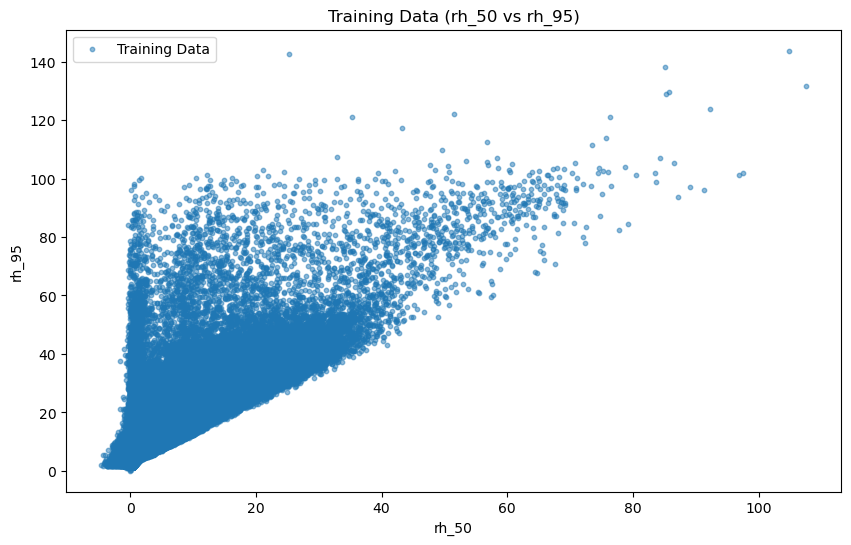

In [9]:
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from IPython.display import Image

OUTPUT_PATH = 'GEDI_outputs/'

feature_names = ['*Canopy Elevation (m)', '*Elevation (m)']
for i in rh_nums:
    feature_names.append(f'*RH {i}')
    feature_names.append(f'*RH {i} Z Score')

features = complete_df[feature_names].values
print('Dimension of input features:' + str(features.shape))
print('Names of each feacture: ' + str(feature_names))

# Split the data into training, development, and testing sets (60% train, 20% dev, 20% test)
X_train, X_temp = train_test_split(features, test_size=0.4, random_state=42)
X_dev, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

# Plot the RH 50 vs RH 95 in the training set
plt.figure(figsize=(10, 6))
plt.scatter(X_train[:, 4], X_train[:, 10], s=10, label='Training Data', alpha=0.5)

# Add labels and title
plt.xlabel('rh_50')
plt.ylabel('rh_95')
plt.title('Training Data (rh_50 vs rh_95)')
plt.legend()

# Save the plot to a file
plt.savefig(OUTPUT_PATH + 'V1_training_data_plot.png')
Image(OUTPUT_PATH + 'V1_training_data_plot.png')
print('Training data plot saved to ' + OUTPUT_PATH + 'V1_training_data_plot.png')

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_dev_scaled = scaler.transform(X_dev)
X_test_scaled = scaler.transform(X_test)

### Gaussian Mixture Model by SciKit-Learn

In [ ]:
# Initialize and fit the Gaussian Mixture Model

aic_scores = []
bic_scores = []
n_components_range = range(1, 11)

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full',  reg_covar=1e-6, random_state=42, verbose=2)
    gmm.fit(X_train_scaled)
    aic_scores.append(gmm.aic(X_train_scaled))
    bic_scores.append(gmm.bic(X_train_scaled))
    log_likelihood = gmm.score(X_train_scaled) * X_train_scaled.shape[0]
    print(f"Log-Likelihood: {log_likelihood}")
    print(f'Fitting for {n} components complete. GMM means: ' + str(gmm.means_))
    print('Shape of GMM means: ' + str(gmm.means_.shape))
    print('Shape of GMM covariances: ' + str(gmm.covariances_.shape))
    print('BIC score: ' + str(bic_scores[-1]))

print(f"Lowest BIC score n_components: {n_components_range[np.argmin(bic_scores)]}")

In [19]:
# Plot BIC score vs. number of components
# Plot the BIC scores
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC vs. Number of Components')
plt.savefig(OUTPUT_PATH + 'V1_elbow_plot.png')
Image(OUTPUT_PATH + 'V1_elbow_plot.png')
print('Elbow plot saved to ' + OUTPUT_PATH + 'V1_elbow_plot.png')

Elbow plot saved to GEDI_outputs/V1_elbow_plot.png


We empirically determine that the optimal number of components is k.

In [11]:
gmm = GaussianMixture(n_components=4, covariance_type='full',  reg_covar=1e-6, random_state=42, verbose=2)
gmm.fit(X_train_scaled)
aic_scores.append(gmm.aic(X_train_scaled))
bic_scores.append(gmm.bic(X_train_scaled))
log_likelihood = gmm.score(X_train_scaled) * X_train_scaled.shape[0]
print(f"Log-Likelihood: {log_likelihood}")
print('Fitting for 4 components complete. GMM means: ' + str(gmm.means_))
print('Shape of GMM means: ' + str(gmm.means_.shape))
print('Shape of GMM covariances: ' + str(gmm.covariances_.shape))

Initialization 0
  Iteration 10	 time lapse 34.13983s	 ll change 0.01970
  Iteration 20	 time lapse 30.94795s	 ll change 0.00335
  Iteration 30	 time lapse 31.12235s	 ll change 0.00836
Initialization converged. time lapse 124.06542s	 lower bound 43.02212.
Log-Likelihood: 116183586.26018536
Fitting for 4 components complete. GMM means: [[-0.53902799 -0.53617077 -0.18245846 -0.18245846 -0.300868   -0.300868
  -0.37297631 -0.37297631 -0.40809626 -0.40809626 -0.46005072 -0.46005072]
 [-0.11361397 -0.12799563  1.58474108  1.58474108  1.78355387  1.78355387
   1.97492256  1.97492256  2.08665919  2.08665919  2.19156644  2.19156644]
 [ 0.71332103  0.71597408 -0.29596845 -0.29596845 -0.3004757  -0.3004757
  -0.31921251 -0.31921251 -0.33280522 -0.33280522 -0.34566225 -0.34566225]
 [ 0.72101167  0.71823416 -0.1397012  -0.1397012   0.1135146   0.1135146
   0.23874668  0.23874668  0.29252938  0.29252938  0.40798002  0.40798002]]
Shape of GMM means: (4, 12)
Shape of GMM covariances: (4, 12, 12)


In [14]:
# Predict the log-likelihood of each sample in the dev set
log_likelihood_dev = gmm.score_samples(X_dev_scaled)

# Set a threshold for identifying outliers based on the training set
threshold = np.percentile(gmm.score_samples(X_train_scaled), 0.1)

# Identify outliers in the validation set
outliers_dev = log_likelihood_dev < threshold

# # Sanity check
# predictions_dev = gmm.predict(X_dev_scaled)

# Add the outlier information to the validation DataFrame
df_dev = pd.DataFrame(X_dev, columns=feature_names)
df_dev['log_likelihood'] = log_likelihood_dev
df_dev['outlier'] = outliers_dev
# df_dev['predicted val'] = predictions_dev

df_dev

,*Canopy Elevation (m),*Elevation (m),*RH 25,*RH 25 Z Score,*RH 50,*RH 50 Z Score,*RH 75,*RH 75 Z Score,*RH 85,*RH 85 Z Score,*RH 95,*RH 95 Z Score,log_likelihood,outlier
0,5086.998535,5057.169434,4.13,2.028735,10.29,2.605383,16.51,2.772993,20.090000,2.863453,25.129999,2.939719,22.186225,False
1,309.821472,306.202362,-1.34,-0.306073,-0.22,-0.338908,0.82,-0.372148,1.340000,-0.393641,2.200000,-0.419618,50.461183,False
2,597.830139,594.497131,-1.31,-0.293268,-0.22,-0.338908,0.78,-0.380166,1.310000,-0.398853,2.090000,-0.435734,45.697167,False
3,68.753059,65.043549,-1.27,-0.276194,-0.22,-0.338908,0.71,-0.394198,1.190000,-0.419698,1.940000,-0.457709,51.479047,False
4,-87.945587,-89.481850,-0.11,0.218939,0.33,-0.184830,0.82,-0.372148,1.040000,-0.445755,1.340000,-0.545612,33.376626,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900161,80.236252,73.935226,-1.23,-0.259121,-0.07,-0.296887,1.11,-0.314016,1.780000,-0.317208,3.350000,-0.251139,37.978509,False
900162,4063.096924,4057.890381,-1.27,-0.276194,-0.07,-0.296887,1.16,-0.303993,1.830000,-0.308523,3.070000,-0.292160,42.704028,False
900163,204.055557,168.858261,5.55,2.634846,15.84,4.160171,23.82,4.238320,27.290001,4.114178,31.690001,3.900785,26.365255,False
900164,105.569168,91.745094,-0.63,-0.003017,0.63,-0.100787,5.50,0.565982,8.800000,0.902248,11.010000,0.871082,27.013305,False


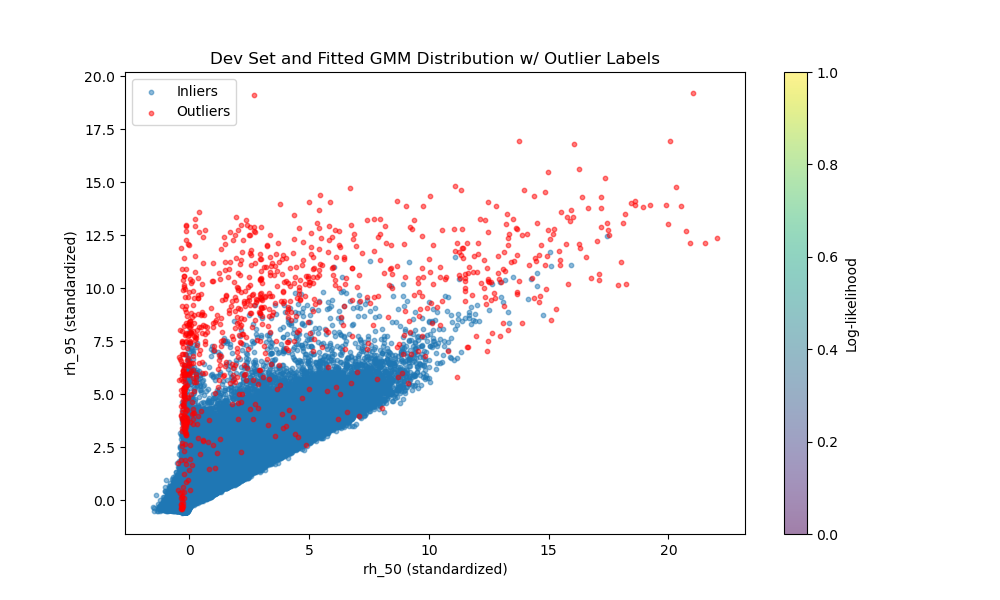

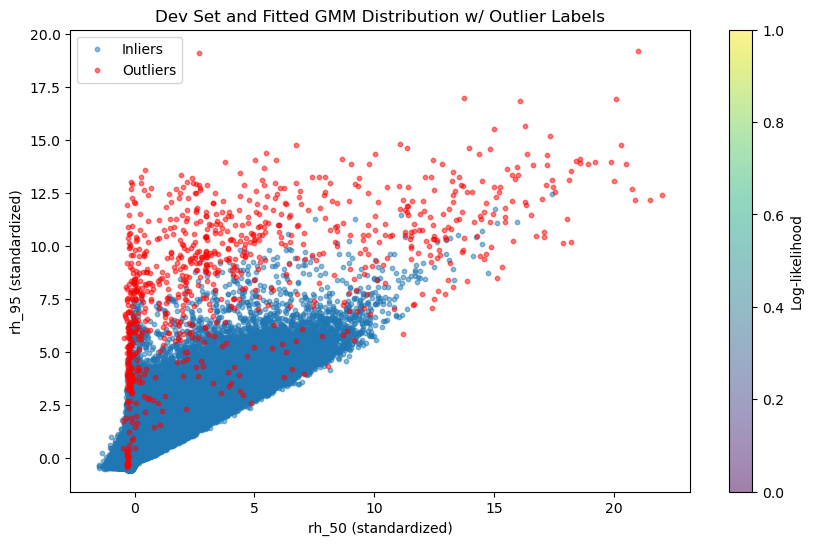

In [15]:
# Generate a grid of points to represent the fitted distribution
# x = np.linspace(X_dev_scaled[:, 0].min() - 1, X_dev_scaled[:, 0].max() + 1, 100)
# y = np.linspace(X_dev_scaled[:, 1].min() - 1, X_dev_scaled[:, 1].max() + 1, 100)
# X, Y = np.meshgrid(x, y)
# XX = np.array([X.ravel(), Y.ravel()]).T
# 
# # Compute the log-likelihood of each point on the grid
# Z = gmm.score_samples(XX)
# Z = Z.reshape(X.shape)

# Plot the development set
plt.figure(figsize=(10, 6))
plt.scatter(X_dev_scaled[~outliers_dev, 4], X_dev_scaled[~outliers_dev, 10], s=10, label='Inliers', alpha=0.5)

# Highlight the outliers
plt.scatter(X_dev_scaled[outliers_dev, 4], X_dev_scaled[outliers_dev, 10], s=10, label='Outliers', alpha=0.5, c='red')

# Plot the fitted GMM distribution as a contour plot
# plt.contour(X, Y, Z, levels=np.linspace(Z.min(), Z.max(), 10), cmap='viridis')

# Add labels and title
plt.xlabel('rh_50 (standardized)')
plt.ylabel('rh_95 (standardized)')
plt.title('Dev Set and Fitted GMM Distribution w/ Outlier Labels')
plt.legend()
plt.colorbar(label='Log-likelihood')
plt.savefig(OUTPUT_PATH + 'gmm_dev_distribution.png')
Image(OUTPUT_PATH + 'gmm_dev_distribution.png')

In [18]:
# Predict the log-likelihood of each sample in the test set
log_likelihood_test = gmm.score_samples(X_test_scaled)

# Set a threshold for identifying outliers based on the training set
threshold = np.percentile(gmm.score_samples(X_train_scaled), 0.1)

# Identify outliers in the validation set
outliers_test = log_likelihood_test < threshold

# Add the outlier information to the validation DataFrame
df_test = pd.DataFrame(X_test, columns=feature_names)
df_test['log_likelihood'] = log_likelihood_test
df_test['outlier'] = outliers_test

df_test

,*Canopy Elevation (m),*Elevation (m),*RH 25,*RH 25 Z Score,*RH 50,*RH 50 Z Score,*RH 75,*RH 75 Z Score,*RH 85,*RH 85 Z Score,*RH 95,*RH 95 Z Score,log_likelihood,outlier
0,42.585621,39.175858,-1.12,-0.212168,-0.18,-0.327702,0.71,-0.394198,1.16,-0.424909,1.87,-0.467964,52.026774,False
1,213.606659,188.871979,4.02,1.981783,9.55,2.398079,13.39,2.147573,15.44,2.055694,19.58,2.126622,27.507125,False
2,69.084488,66.274254,-1.04,-0.178021,-0.14,-0.316497,0.74,-0.388184,1.19,-0.419698,1.87,-0.467964,52.002349,False
3,-18.502741,-21.048777,-0.82,-0.084117,0.00,-0.277277,0.86,-0.364130,1.27,-0.405801,1.94,-0.457709,50.452411,False
4,153.894073,138.871292,-0.14,0.206134,2.69,0.476305,9.74,1.415912,11.42,1.357373,13.18,1.188996,26.795518,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900161,18.243055,15.220489,-1.00,-0.160948,-0.07,-0.296887,0.85,-0.366134,1.34,-0.393641,2.08,-0.437199,51.828905,False
900162,2922.727783,2916.125488,-1.60,-0.417051,0.14,-0.238057,2.01,-0.133606,3.09,-0.089646,4.73,-0.048963,37.698080,False
900163,68.134605,65.062088,-1.12,-0.212168,-0.14,-0.316497,0.71,-0.394198,1.19,-0.419698,1.91,-0.462104,50.348029,False
900164,528.454407,511.745453,0.52,0.487847,4.45,0.969355,8.80,1.227484,10.97,1.279202,13.89,1.293014,32.226099,False


In [ ]:
# Generate a grid of points to represent the fitted distribution
x = np.linspace(X_test_scaled[:, 0].min() - 1, X_test_scaled[:, 0].max() + 1, 100)
y = np.linspace(X_test_scaled[:, 1].min() - 1, X_test_scaled[:, 1].max() + 1, 100)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

# Compute the log-likelihood of each point on the grid
Z = gmm.score_samples(XX)
Z = Z.reshape(X.shape)

# Plot the test set
plt.figure(figsize=(10, 6))
plt.scatter(X_test_scaled[~outliers_test, 0], X_test_scaled[~outliers_test, 1], s=10, label='Inliers', alpha=0.5)

# Highlight the outliers
plt.scatter(X_test_scaled[outliers_test, 0], X_test_scaled[outliers_test, 1], s=10, label='Outliers', alpha=0.5, c='red')

# Plot the fitted GMM distribution as a contour plot
plt.contour(X, Y, Z, levels=np.linspace(Z.min(), Z.max(), 10), cmap='viridis')

# Add labels and title
plt.xlabel('rh_50 (standardized)')
plt.ylabel('rh_98 (standardized)')
plt.title('Testing Set & Fitted GMM Distribution w/ Outlier Labels')
plt.legend()
plt.colorbar(label='Log-likelihood')
plt.savefig(OUTPUT_PATH + 'gmm_test_distribution.png')
Image(OUTPUT_PATH + 'gmm_test_distribution.png')

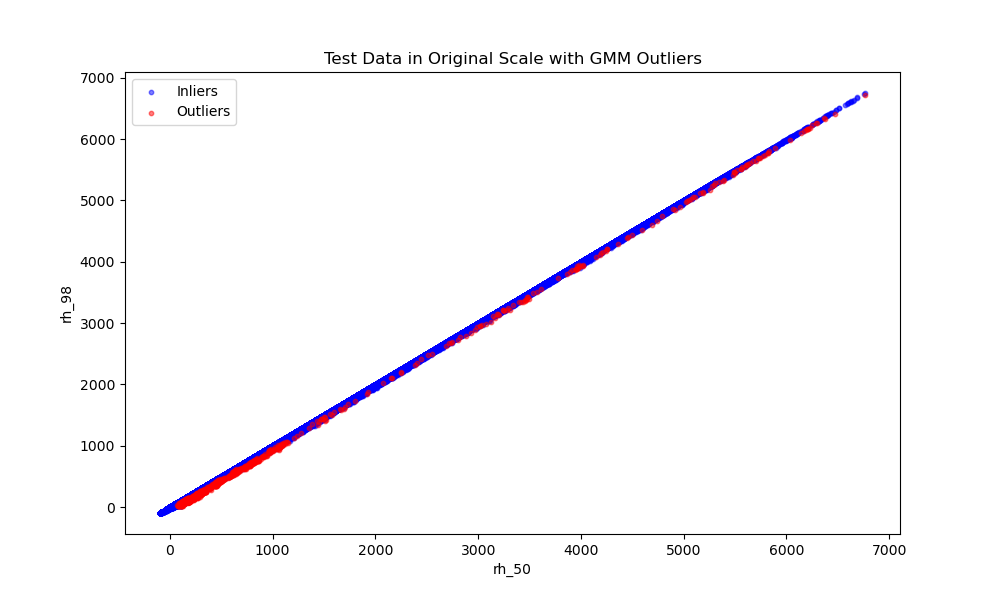

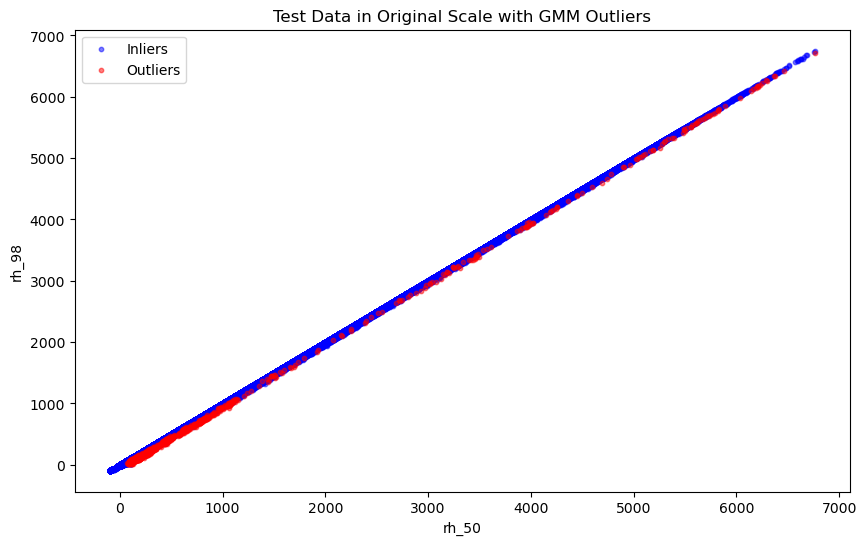

In [22]:
# Plotting the test data in the original scale

# Inverse transform the scaled test data back to the original scale
X_test_original = scaler.inverse_transform(X_test_scaled)

# Plot the test data in its original scale
plt.figure(figsize=(10, 6))
plt.scatter(X_test_original[~outliers_test, 0], X_test_original[~outliers_test, 1], s=10, label='Inliers', alpha=0.5, c='blue')
plt.scatter(X_test_original[outliers_test, 0], X_test_original[outliers_test, 1], s=10, label='Outliers', alpha=0.5, c='red')
plt.xlabel('rh_50')
plt.ylabel('rh_98')
plt.title('Test Data in Original Scale with GMM Outliers')
plt.legend()
plt.savefig(OUTPUT_PATH + 'GMM_Test_OUTPUT.png')
Image(OUTPUT_PATH + 'GMM_Test_OUTPUT.png')

### Be sure to close all plots to avoid using up RAM.

In [66]:
plt.close('all')

### Isolation Forest Model by SciKit-Learn

In [99]:
from sklearn.ensemble import IsolationForest

# Train the Isolation Forest model
iso_forest = IsolationForest(contamination=0.015, max_features=2)
iso_forest.fit(X_train_scaled)

IsolationForest(contamination=0.015, max_features=2)

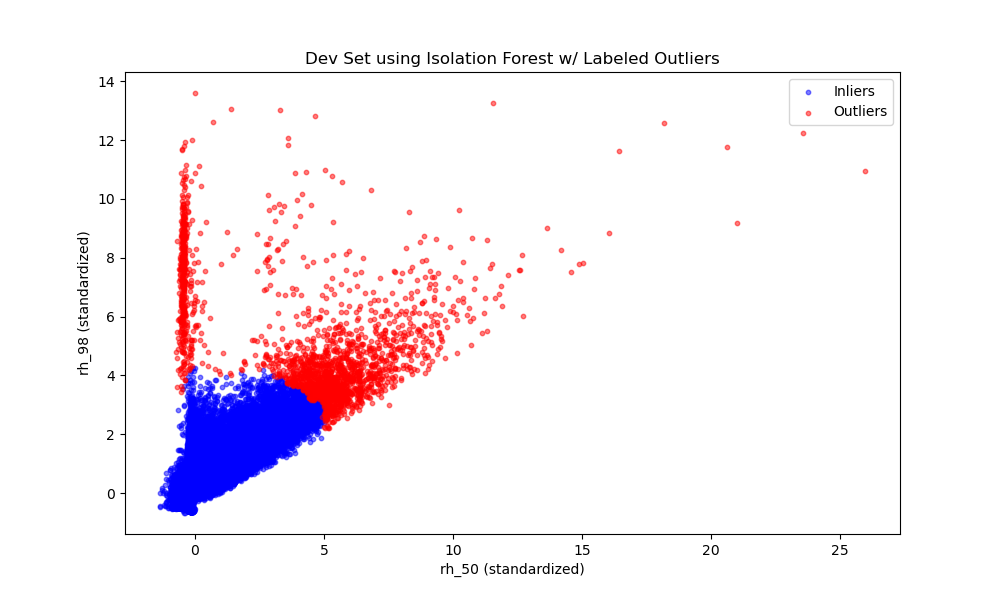

In [100]:
# Predict outliers in the dev set
outliers_dev = iso_forest.predict(X_dev_scaled) == -1

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_dev_scaled[~outliers_dev, 0], X_dev_scaled[~outliers_dev, 1], s=10, label='Inliers', alpha=0.5, c='blue')
plt.scatter(X_dev_scaled[outliers_dev, 0], X_dev_scaled[outliers_dev, 1], s=10, label='Outliers', alpha=0.5, c='red')
plt.xlabel('rh_50 (standardized)')
plt.ylabel('rh_98 (standardized)')
plt.title('Dev Set using Isolation Forest w/ Labeled Outliers')
plt.legend()
plt.savefig(OUTPUT_PATH + 'Iso_Forest_Dev_Output.png')
Image(OUTPUT_PATH + 'Iso_Forest_Dev_Output.png')

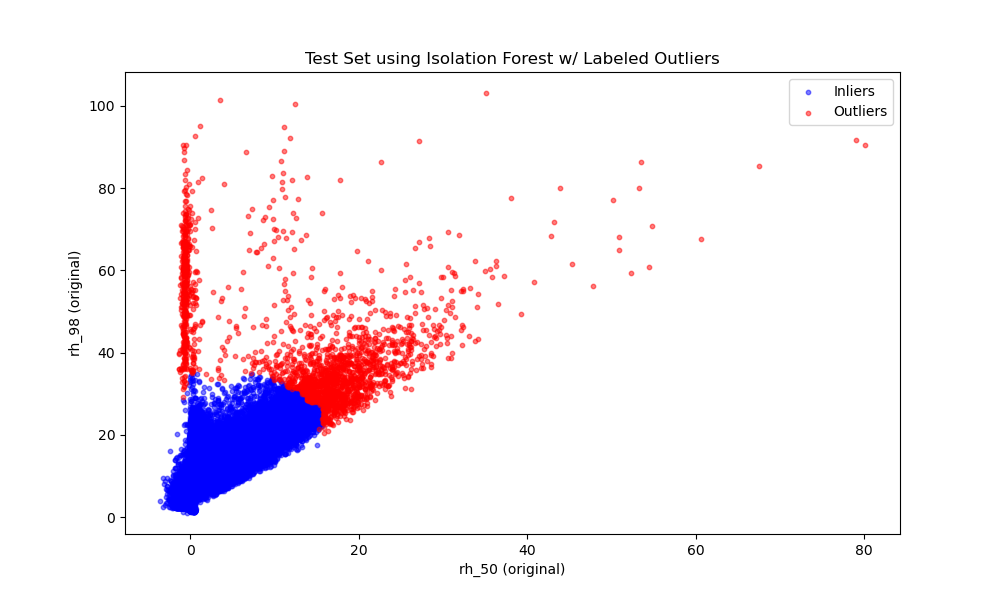

In [101]:
# Predict outliers in the test set
outliers_test = iso_forest.predict(X_test_scaled) == -1

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test_original[~outliers_test, 0], X_test_original[~outliers_test, 1], s=10, label='Inliers', alpha=0.5, c='blue')
plt.scatter(X_test_original[outliers_test, 0], X_test_original[outliers_test, 1], s=10, label='Outliers', alpha=0.5, c='red')
plt.xlabel('rh_50 (original)')
plt.ylabel('rh_98 (original)')
plt.title('Test Set using Isolation Forest w/ Labeled Outliers')
plt.legend()
plt.savefig(OUTPUT_PATH + 'Iso_Forest_Test_Output.png')
Image(OUTPUT_PATH + 'Iso_Forest_Test_Output.png')

In [102]:
plt.close('all')

### DBSCAN Model by SciKit-Learn
WARNING: DO NOT RUN! This causes a bluescreen.

In [ ]:
# from sklearn.cluster import DBSCAN
# 
# # Apply DBSCAN
# dbscan = DBSCAN(eps=0.3, min_samples=5)
# dbscan.fit(X_train_scaled)

In [ ]:
# # Predict outliers in the test set
# outliers_dev = dbscan.fit_predict(X_dev_scaled) == -1
# 
# # Plot the test data in its original scale
# plt.figure(figsize=(10, 6))
# plt.scatter(X_dev_scaled[~outliers_dev, 0], X_dev_scaled[~outliers_dev, 1], s=10, label='Inliers', alpha=0.5, c='blue')
# plt.scatter(X_dev_scaled[outliers_dev, 0], X_dev_scaled[outliers_dev, 1], s=10, label='Outliers', alpha=0.5, c='red')
# plt.xlabel('rh_50')
# plt.ylabel('rh_98')
# plt.title('Test Data in Original Scale with DBSCAN Outliers')
# plt.legend()
# plt.savefig(OUTPUT_PATH + 'DBSCAN_Dev_Output.png')
# Image(OUTPUT_PATH + 'DBSCAN_Dev_Output.png')